# Exploratory data analysis

## 1. Dataset description

1) Global COVID-19 datasets

- The two COVID-19 datasets, [the global confirmed dataset](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv) and [the global death dataset](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv), are from the [data repository](https://github.com/CSSEGISandData/COVID-19) for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). The dataset is updated every day starting from January 22nd, 2020.

- Both datasets contain columns of location information (`Province/State`, `Country/Region`, `Lat`, and `Long`) or daily accumulated numbers of confirmed or deaths in the corresponding location, starting from `1/22/20` to present.

- As stated in the dataset repository, "Australia, Canada and China are reported at the province/state level. Dependencies of the Netherlands, the UK, France and Denmark are listed under the province/state level. The US and other countries are at the country level."

- The datasets combine data from multiple sources and may contain mistakes.



## 2. Load the dataset

In [114]:
import requests, json, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy.stats as stats
from scipy.interpolate import interp1d
from pylab import rcParams


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm

import pmdarima
from pmdarima.arima import ndiffs

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor


pd.set_option('display.max_rows', 6)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10,
#                      'axes.labelweight': 'bold',
                     'figure.figsize': (6, 5)})

In [147]:
# the following functions are borrowed from https://github.com/TomasBeuzen/machine-learning-tutorials/blob/master/ml-timeseries/notebooks/supervised_time_series_intro.ipynb
# Custom functions
def lag_df(df, lag, cols):
    return df.assign(**{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols})


def ts_predict(input_data, model, n=20, responses=1):
    predictions = []
    n_features = input_data.size
    for _ in range(n):

        predictions = np.append(predictions,
                                model.predict(input_data.reshape(1, -1)))  # make prediction
        input_data = np.append(predictions[-responses:],
                               input_data[:n_features-responses])  # new input data
    return predictions.reshape((-1, responses))


def plot_ts(ax, df_train, df_test, predictions, xlim, response_cols):
    col_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, col in enumerate(response_cols):
        ax.plot(df_train[col], '-', c=col_cycle[i], label = f'Train {col}')
        ax.plot(df_test[col], '--', c=col_cycle[i], label = f'Validation {col}')
        ax.plot(np.arange(df_train.index[-1] + 1,
                          df_train.index[-1] + 1 + len(predictions)),
                predictions[:,i], c=col_cycle[-i-2], label = f'Prediction {col}')
    ax.set_xlim(0, xlim+1)
    ax.set_title(f"Train Shape = {len(df_train)}, Validation Shape = {len(df_test)}",
                fontsize=16)
    ax.set_ylabel(df_train.columns[0])


    
def create_rolling_features(df, columns, windows=[6, 12]):
    for window in windows:
        df["rolling_mean_" + str(window)] = df[columns].rolling(window=window).mean()
        df["rolling_std_" + str(window)] = df[columns].rolling(window=window).std()
        df["rolling_var_" + str(window)] = df[columns].rolling(window=window).var()
        df["rolling_min_" + str(window)] = df[columns].rolling(window=window).min()
        df["rolling_max_" + str(window)] = df[columns].rolling(window=window).max()
        df["rolling_min_max_ratio_" + str(window)] = df["rolling_min_" + str(window)] / df["rolling_max_" + str(window)]
        df["rolling_min_max_diff_" + str(window)] = df["rolling_max_" + str(window)] - df["rolling_min_" + str(window)]

    df = df.replace([np.inf, -np.inf], np.nan)    
    df.fillna(0, inplace=True)
    return df

def get_accuracy(pred, obs):
    acc = {}
     
    # Mean Absolute Percentage Error
    acc['MAPE'] = np.mean(np.abs(pred - obs)/np.abs(obs))
    
    acc['Correlation'] = np.corrcoef(pred, obs)[0,1]
    
    mins = np.amin(np.hstack([pred[:, None], 
                              obs[:, None]]), 
                   axis=1)
    maxs = np.amax(np.hstack([pred[:, None], 
                              obs[:, None]]), 
                   axis=1)
    acc['Min-Max Error'] = 1 - np.mean(mins/maxs)       

    return acc

In [159]:
def plot_forecast(model_fit, train, obs, auto=False):
    
    if not auto:
        # Forecast with 95% conf
        fc, se, conf = model_fit.forecast(obs.size, alpha=0.05) 

    else:
        model_fit.plot_diagnostics(figsize=(10, 10))
        plt.show()
        
        # Forecast
        fc, conf = model_fit.predict(n_periods=int(valid.size), return_conf_int=True)

    
    # Make as pandas series
    fc_series = pd.Series(fc, index=obs.index)
    lower_series = pd.Series(conf[:, 0], index=obs.index)
    upper_series = pd.Series(conf[:, 1], index=obs.index)

    # Plot
    plt.figure(figsize=(12, 5), dpi=100)
    plt.plot(train.close, label='training')
    plt.plot(obs.close, label='observation')
    plt.plot(fc_series, label='prediction')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Observation vs Prediction')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    return fc_series




In [2]:
params = {'function': 'FX_DAILY',
          'from_symbol': 'CAD',
          'to_symbol': 'USD',
          'outputsize': 'full',
          'apikey': os.environ['ALPHA_API']}

url = "https://www.alphavantage.co/query"
response = requests.get(url, params)

json_data = response.json()
    
# Check if the request was successful, if not raise an
# exception
if 'Error Message' in list(json_data.keys()):    
    raise Exception("Request failed.")

# Create the pandas dataframe (see: pd.read_json() )
data = pd.DataFrame(json_data[list(json_data.keys())[1]]).\
transpose().apply(pd.to_numeric).reset_index()

data.columns = ['date', 'open', 'high', 'low', 'close']
data.date = pd.to_datetime(data.date)

data.head()

,date,open,high,low,close
0,2020-06-11,0.7446,0.7460,0.7332,0.7343
1,2020-06-10,0.7447,0.7507,0.7437,0.7454
2,2020-06-09,0.7467,0.7483,0.7410,0.7451
3,2020-06-08,0.7452,0.7485,0.7438,0.7471
4,2020-06-05,0.7411,0.7465,0.7396,0.7443


In [94]:
sub_data =\
pd.merge(
    pd.DataFrame(
        pd.date_range(
            start='2016-01-01',
            end='2019-12-31'),
        columns=['date']),
    data, how='left')

In [95]:
sub_data.to_csv('../data/raw_data/cad_to_usd_2016-2019.csv', index=False)

## 3. Explore the dataset

## 4. Initial thoughts


## 5. Wrangling

In [96]:
cad_to_usd = pd.read_csv('../data/raw_data/cad_to_usd_2016-2019.csv')
# data imputation with last observation carried over
cad_to_usd = cad_to_usd.fillna(method='ffill')

cad_to_usd.head()

,date,open,high,low,close
0,2016-01-01,0.7223,0.7226,0.7214,0.7226
1,2016-01-02,0.7223,0.7226,0.7214,0.7226
2,2016-01-03,0.7223,0.7226,0.7214,0.7226
3,2016-01-04,0.7205,0.7222,0.7147,0.7178
4,2016-01-05,0.7175,0.7193,0.7129,0.7150


In [97]:
cad_to_usd = cad_to_usd.set_index('date')

Split data into train, valid and test datasets

In [45]:
split_ratio = 0.95

split_1 = int(cad_to_usd.shape[0] * split_ratio)
train_valid, test = cad_to_usd[['close']].iloc[: split_1], cad_to_usd[['close']].iloc[split_1:]

split_2 = int(train_valid.shape[0] * split_ratio)
train, valid = train_valid.iloc[: split_2], train_valid.iloc[split_2:]

print(f'The shape of train is {train.shape}')
print(f'The shape of valid is {valid.shape}')
print(f'The shape of test is {test.shape}')

The shape of train is (658, 1)
The shape of valid is (35, 1)
The shape of test is (37, 1)


## 6. Research questions



## 7. Data Analysis & Visualizations

Visualize the time series data

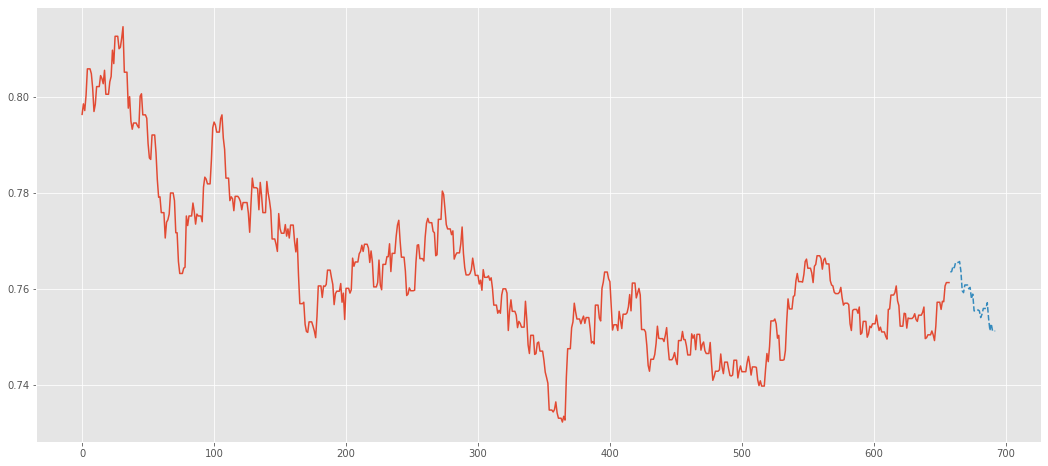

In [164]:
rcParams['figure.figsize'] = 18, 8
plt.plot(train.close, '-')
plt.plot(valid.close, '--')
# plt.plot(test.close, '-')

Decompose the process:

$y_t = T_t + S_t + R_t$

where $y_t$ is the data, $T_t$ is the trend-cycle component, $S_t$ is the seasonal component, and $R_t$ is the remainder component, all at period $t$. 

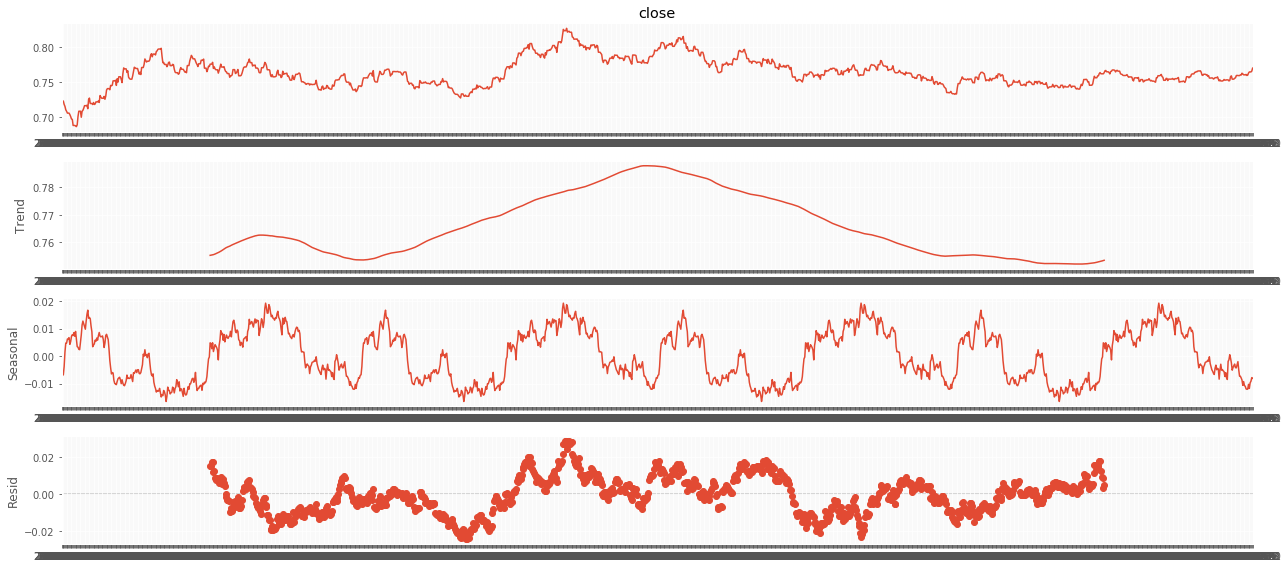

In [116]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(cad_to_usd.close, period=365, model='additive')
fig = decomposition.plot()
plt.show()

Based on the decomposition results, the process is not stationary.

#### 1. ARIMA 

1.1 ARIMA by hand


In [163]:
result = adfuller(train.close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.504658
p-value: 0.114345


The null hypothesis of the ADF test is that the time series is non-stationary. The p-value is bigger than the significance level (0.05). I would try to difference the series

Find the order of the AR term (p), the order of differencing (d) and the order of the MA term (q) in ARIMA model


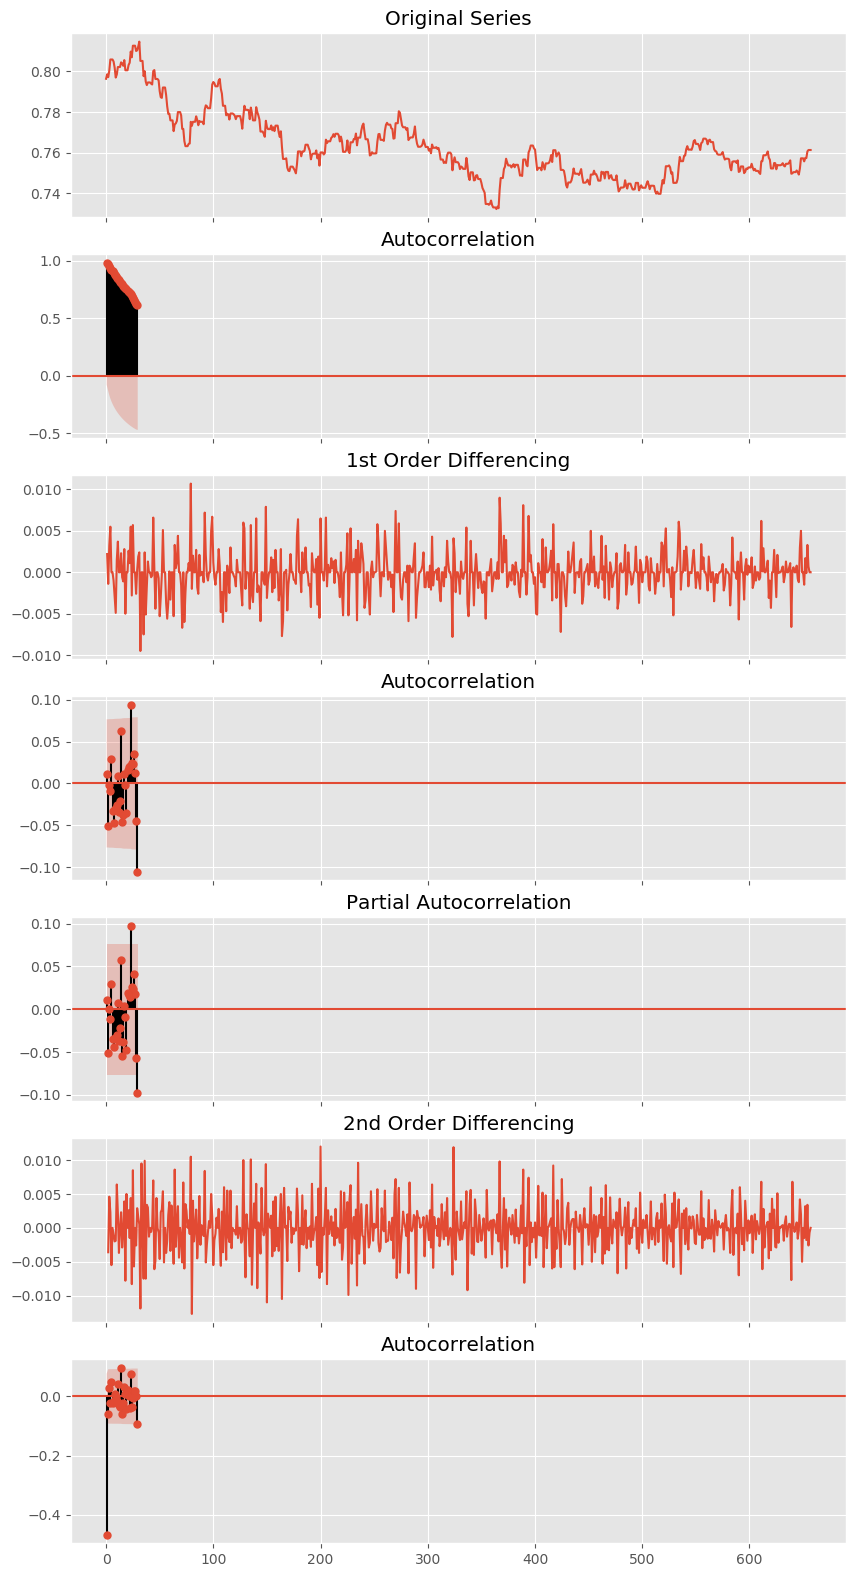

In [165]:
# ref: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

fig, axes = plt.subplots(7, sharex=True, figsize=(10, 20), dpi=100)

# original series
axes[0].plot(train.close)
axes[0].set_title('Original Series')
plot_acf(train.close, ax=axes[1], zero=False)

# 1st Differencing
axes[2].plot(train.close.diff())
axes[2].set_title('1st Order Differencing')
plot_acf(train.close.diff().dropna(), ax=axes[3], zero=False)
plot_pacf(train.close.diff().dropna(), ax=axes[4], zero=False)

# 2nd Differencing
axes[5].plot(train.close.diff().diff())
axes[5].set_title('2nd Order Differencing')
plot_acf(train.close.diff().diff().dropna(), ax=axes[6], zero=False)

plt.show()

The ACF plot of the first order differencing decreases to zero quickly, so I would choose d as 1 and q as 1.

The PACF plot of the first order differencing decreases to zero quickly, so I would choose p as 1.


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  657
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2994.492
Method:                       css-mle   S.D. of innovations              0.003
Date:                Thu, 11 Jun 2020   AIC                          -5980.984
Time:                        22:06:26   BIC                          -5963.033
Sample:                             1   HQIC                         -5974.024
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.342e-05      0.000     -0.531      0.596      -0.000       0.000
ar.L1.D.close    -0.7377      0.260     -2.842      0.004      -1.246      -0.229
ma.L1.D.close     0.7674      0.246     

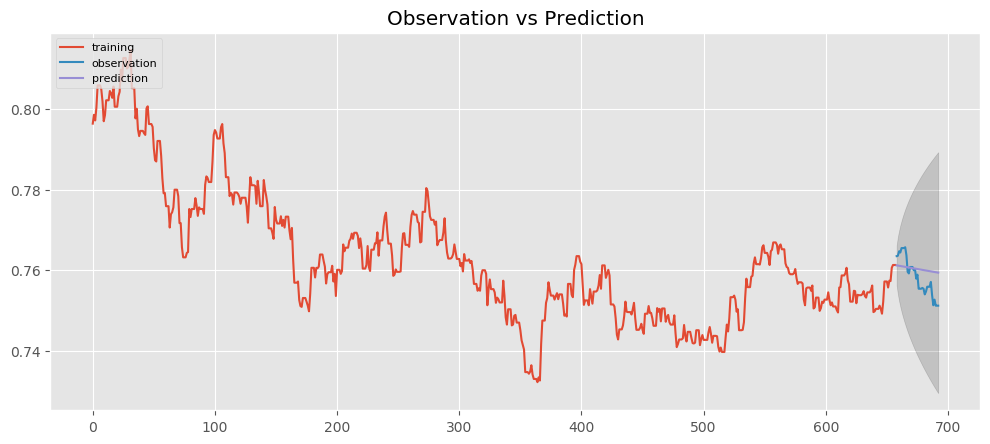

In [157]:
model_1 = ARIMA(train.close, order=(1, 1, 1))
model_1_fit = model_1.fit(disp=-1)
print(model_1_fit.summary())
fc_series = plot_forecast(model_1_fit, train, valid)
acc_1 = get_accuracy(fc_series, valid.squeeze())

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                  658
Model:                     ARMA(1, 0)   Log Likelihood                2997.956
Method:                       css-mle   S.D. of innovations              0.003
Date:                Thu, 11 Jun 2020   AIC                          -5989.911
Time:                        22:06:47   BIC                          -5976.443
Sample:                             0   HQIC                         -5984.690
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7665      0.008     91.637      0.000       0.750       0.783
ar.L1.close     0.9894      0.006    177.873      0.000       0.979       1.000
                                    Roots       

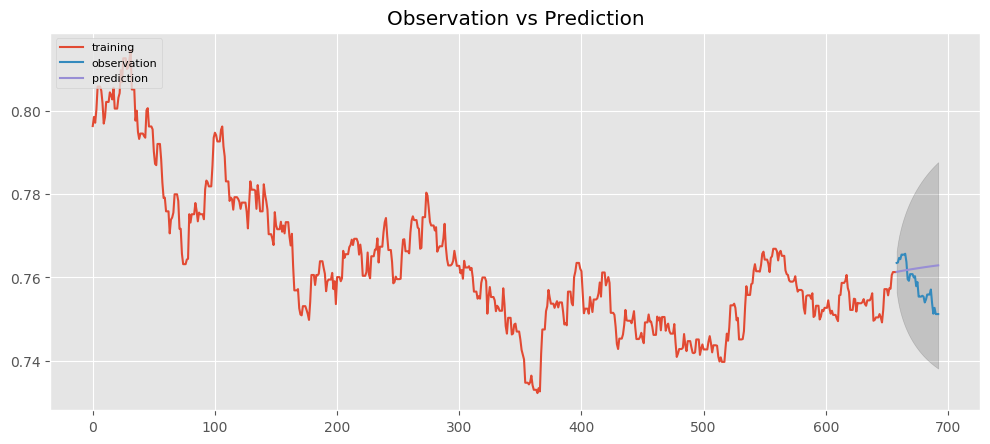

In [158]:
model_2 = ARIMA(train.close, order=(1, 0, 0))
model_2_fit = model_2.fit(disp=-1)
print(model_2_fit.summary())
fc_series = plot_forecast(model_2_fit, train, valid)
acc_2 = get_accuracy(fc_series, valid.squeeze())

1.2 Auto ARIMA Forecast

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-5979.994, BIC=-5962.044, Time=0.409 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-5983.715, BIC=-5974.740, Time=0.203 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-5981.793, BIC=-5968.330, Time=0.227 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-5981.795, BIC=-5968.332, Time=0.417 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-5985.424, BIC=-5980.936, Time=0.172 seconds
Total fit time: 1.442 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  658
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2993.712
Date:                Thu, 11 Jun 2020   AIC                          -5985.424
Time:                        22:11:45   BIC                          -5980.936
Sample:                             0   HQIC                 

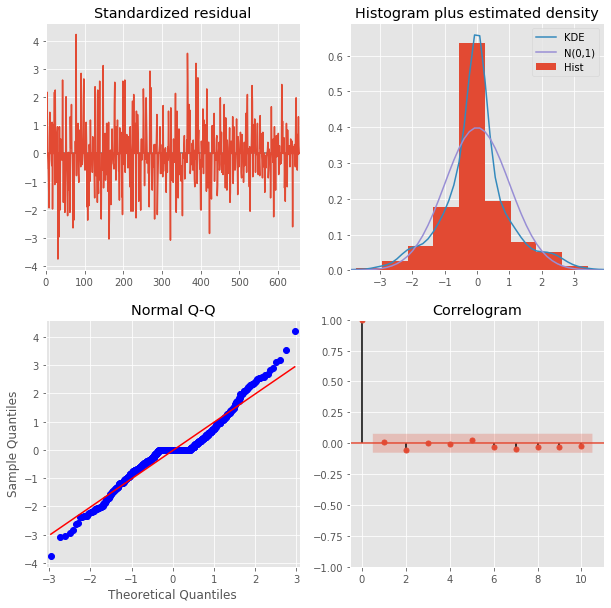

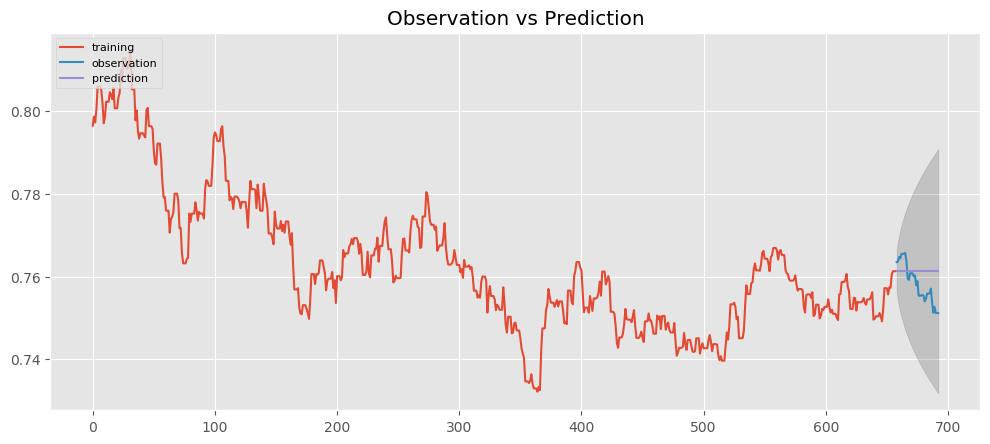

In [161]:
model_3 = pmdarima.auto_arima(train['close'],
                            start_p=1,
                            start_q=1,
                            test='adf',       
                            max_p=3,
                            max_q=3,
                            m=1,
                            d=None,
                            seasonal=False,
                            start_P=0,
                            D=None,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(model_3.summary())
fc_series = plot_forecast(model_3, train, valid, True)
acc_3 = get_accuracy(fc_series, valid.squeeze())

Auto SARIMA Forecast

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,7) [intercept=True]; AIC=-5781.346, BIC=-5758.953, Time=1.308 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=True]; AIC=-4703.276, BIC=-4694.319, Time=0.184 seconds
Fit ARIMA(1,0,0)x(1,1,0,7) [intercept=True]; AIC=-5698.030, BIC=-5680.116, Time=1.387 seconds
Fit ARIMA(0,0,1)x(0,1,1,7) [intercept=True]; AIC=-5223.382, BIC=-5205.468, Time=3.214 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=False]; AIC=-4702.121, BIC=-4697.642, Time=0.111 seconds
Fit ARIMA(1,0,1)x(0,1,0,7) [intercept=True]; AIC=-5504.169, BIC=-5486.255, Time=0.564 seconds
Fit ARIMA(1,0,1)x(1,1,1,7) [intercept=True]; AIC=-5725.194, BIC=-5698.323, Time=2.228 seconds
Fit ARIMA(1,0,1)x(0,1,2,7) [intercept=True]; AIC=-5808.116, BIC=-5781.245, Time=8.990 seconds
Fit ARIMA(1,0,1)x(1,1,2,7) [intercept=True]; AIC=-5808.496, BIC=-5777.146, Time=5.099 seconds
Fit ARIMA(1,0,1)x(2,1,2,7) [intercept=True]; AIC=-5729.508, BIC=-5693.680, Time=3.196 seconds
Fit ARIMA(1,0,1)

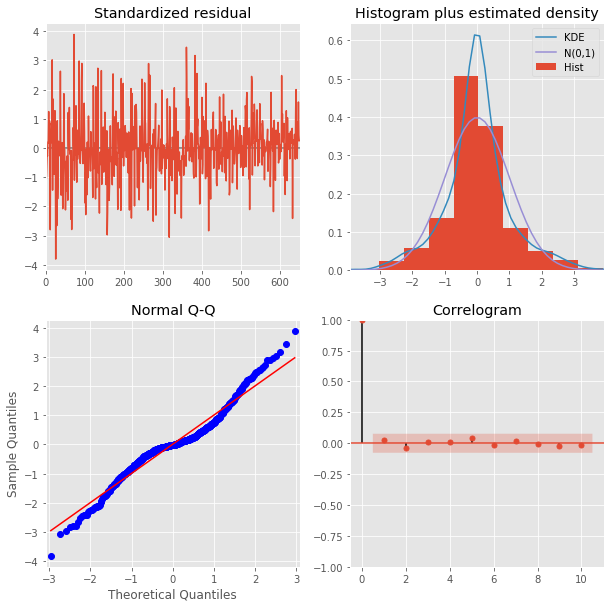

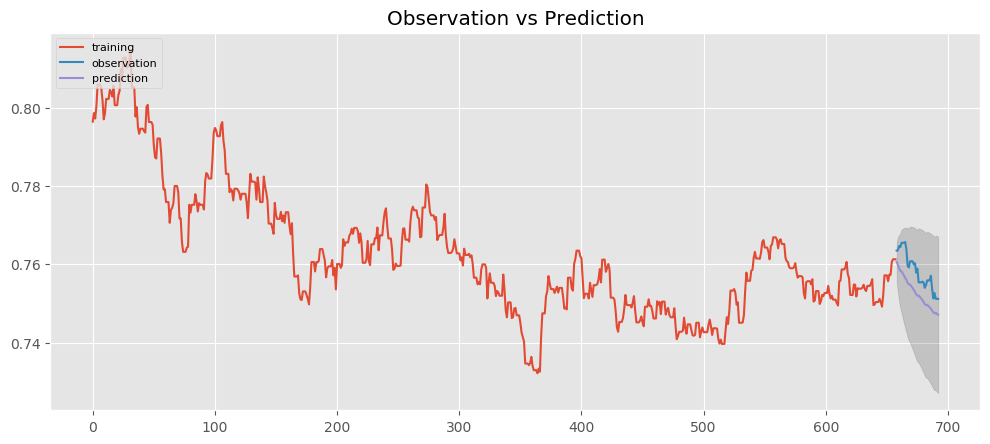

In [162]:
# Seasonal - fit stepwise auto-ARIMA
model_4 = pmdarima.auto_arima(train['close'], 
                             start_p=1, 
                             start_q=1,
                             test='adf',
                             max_p=3, 
                             max_q=3, 
                             m=7,
                             start_P=0,
                             seasonal=True,
                             d=None,
                             D=1,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

model_4.summary()
fc_series = plot_forecast(model_4, train, valid, True)
acc_4 = get_accuracy(fc_series, valid.squeeze())

In [168]:
results = {}
for key in acc_1.keys():
    results[key] = [acc_1[key], acc_2[key], acc_3[key], acc_4[key]]

    
pd.DataFrame(
    results, 
    index=\
    ['ARIMA(1, 1, 1)', 
     'ARIMA(1, 0, 0)',
     'ARIMA(0, 1, 0) no intercept',
     'ARIMA(1, 0, 0) x (1, 1, 1, 7)'])

,MAPE,Correlation,Min-Max Error
"ARIMA(1, 1, 1)",0.005125,9.420275e-01,0.005096
"ARIMA(1, 0, 0)",0.007176,-9.416983e-01,0.007110
"ARIMA(0, 1, 0) no intercept",0.006189,3.439489e-15,0.006142
"ARIMA(1, 0, 0) x (1, 1, 1, 7)",0.007395,9.382922e-01,0.007395


Based on the prediction accuracy, ARIMA(1, 1, 1) is the best ARIMA model.

#### 2. Classic supervise learning

2.1 Random Forests

In [ ]:
# the number of lagged features in the model
lag = 15  
# the number of train/validation splits
n_splits = 8  
response_col = ['close']
df_lag = lag_df(cad_to_usd[['close']], lag, response_col).dropna()
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
model = RandomForestRegressor()  # define the model

cv = cross_validate(model,
                    X = df_lag.drop(columns=response_col),
                    y = df_lag[response_col[0]],
                    cv=tscv,
                    return_train_score=True)

pd.DataFrame({'split': range(n_splits),
              'train_r2': cv['train_score'],
              'validation_r2': cv['test_score']}).set_index('split')

In [ ]:
fig, ax = plt.subplots(n_splits, 1, figsize=(8, 4*n_splits))
for i, (train_index, test_index) in enumerate(tscv.split(df_lag)):
    df_train, df_test = df_lag.iloc[train_index], df_lag.iloc[test_index]
    model = RandomForestRegressor().fit(df_train.drop(columns=response_col),
                                        df_train[response_col[0]])  # train model
    # Prediction loop
    predictions = model.predict(df_test.drop(columns=response_col))[:,None]

    # Plot
    plot_ts(ax[i], df_train, df_test, predictions, xlim=df_lag.index[-1], response_cols=response_col)
ax[0].legend(facecolor='w')
ax[i].set_xlabel('time')
fig.tight_layout()

In [ ]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
model = RandomForestRegressor()  # define the model
# search loop
l = []
cv_mean = []
cv_std = []
response_col = ['close']
for lag in range(1, 21):
    df_lag = lag_df(train, lag, response_col).dropna()  # drop the na
    cv_score = cross_validate(model,
                              df_lag.drop(columns=response_col),
                              df_lag[response_col[0]],
                              cv=tscv)
    l.append(lag)
    cv_mean.append(round(cv_score['test_score'].mean(),3))
    cv_std.append(round(cv_score['test_score'].std(),3))
(pd.DataFrame({'lag': l,
               'cv_mean': cv_mean,
               'cv_std': cv_std}).set_index('lag')
                                 .sort_values(by='cv_mean', ascending=False)
                                 .head(10)
)

In [ ]:
lag = 2
n = 24  # number of steps to forecast
response_col = ['close']
fig, ax = plt.subplots(1, 1, figsize=(8,5))
df_lag = lag_df(train, lag, response_col).dropna()
model = RandomForestRegressor().fit(df_lag.drop(columns=response_col),
                                    df_lag[response_col[0]])  # train model
# Prediction loop
input_data = df_lag.iloc[-1, :lag*train.shape[1]].to_numpy()  # starting data for first prediction
predictions = ts_predict(input_data, model, n) # custom forecast function

# Plot
plot_forecast(ax, df_lag, predictions, xlim=df_lag.index[-1], response_cols=response_col)
ax.legend(loc=3, facecolor='w')
ax.set_xlabel('time');

Differencing

Stationarity means that the mean and variance of the series is finite and does not change over time. Thus, it implies some stability in the statistical properties of the time series.

In [ ]:
ndiffs(train)

In [ ]:
train_trans = np.log(train).diff().dropna()

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_trans.close, label='training')

plt.title('Transformed train')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.diff().close, label='training')

plt.title('Transformed train')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
trans = train.copy()

In [ ]:
trans['trans_1'], lamb = stats.boxcox(train.close)

In [ ]:
trans['trans'] = trans.trans_1.diff()

In [ ]:

plt.figure(figsize=(12,5), dpi=100)
plt.plot(trans.trans, label='training')

plt.title('Transformed train')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
model = RandomForestRegressor()  # define the model
# search loop
l = []
cv_mean = []
cv_std = []
response_col = ['close']
for lag in range(1, 21):
    df_lag = lag_df(train_trans, lag, response_col).dropna()  # drop the na
    cv_score = cross_validate(model,
                              df_lag.drop(columns=response_col),
                              df_lag[response_col[0]],
                              cv=tscv)
    l.append(lag)
    cv_mean.append(round(cv_score['test_score'].mean(),3))
    cv_std.append(round(cv_score['test_score'].std(),3))
(pd.DataFrame({'lag': l,
               'cv_mean': cv_mean,
               'cv_std': cv_std}).set_index('lag')
                                 .sort_values(by='cv_mean', ascending=False)
                                 .head(10)
)

In [ ]:
lag = 1
n = 24  # number of steps to forecast
response_col = ['close']
fig, ax = plt.subplots(1, 1, figsize=(8,5))
df_lag = lag_df(train_trans, lag, response_col).dropna()
model = RandomForestRegressor().fit(df_lag.drop(columns=response_col),
                                    df_lag[response_col[0]])  # train model
# Prediction loop
input_data = df_lag.iloc[-1, :lag*train.shape[1]].to_numpy()  # starting data for first prediction
predictions = ts_predict(input_data, model, n) # custom forecast function

# Plot
plot_forecast(ax, df_lag, predictions, xlim=df_lag.index[-1], response_cols=response_col)
ax.legend(loc=3, facecolor='w')
ax.set_xlabel('time');

In [ ]:
lag = 1
n = 24  # number of steps to forecast
response_col = ['trans']
fig, ax = plt.subplots(1, 1, figsize=(8,5))
df_lag = lag_df(trans[['trans']], lag, response_col).dropna()
model = RandomForestRegressor().fit(df_lag.drop(columns=response_col),
                                    df_lag[response_col[0]])  # train model
# Prediction loop
input_data = df_lag.iloc[-1, :lag*train.shape[1]].to_numpy()  # starting data for first prediction
predictions = ts_predict(input_data, model, n) # custom forecast function

# Plot
plot_forecast(ax, df_lag, predictions, xlim=df_lag.index[-1], response_cols=response_col)
ax.legend(loc=3, facecolor='w')
ax.set_xlabel('time')

In [ ]:
np.cumsum(predictions)

In [ ]:
trans.trans_1.iloc[0]

In [ ]:
np.exp(np.log(lamb*(trans.trans_1.iloc[-1] + np.cumsum(predictions))+ 1)/lamb)

In [ ]:
predict = np.exp(np.log(lamb*(trans.trans_1.iloc[-1] + np.cumsum(predictions))+ 1)/lamb)

In [ ]:
predict = pd.Series(predict, index=valid.index)

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.close, label='training')
plt.plot(valid.close, label='actual')
plt.plot(predict, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
lag = 1
n = 24  # number of steps to forecast
response_col = ['close']
df_lag = lag_df(train, lag, response_col).dropna()
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
# calculation loop
k_dict = {'k':[], 'train_error':[], 'cv_error': []}

for k in np.arange(1, 51):
    model = KNeighborsRegressor(n_neighbors=k).fit(df_lag.drop(columns=response_col),
                                    df_lag[response_col[0]])
    k_dict['k'].append(k)    
    k_dict['train_error'].append(mean_squared_error(model.predict(df_lag.drop(columns=response_col)),
                                                 df_lag[response_col[0]])) 
    k_dict['cv_error'].append(-cross_val_score(model,
                                                  df_lag.drop(columns=response_col),
                                                  df_lag[response_col[0]],
                                              scoring='neg_mean_squared_error',
                                                  cv=tscv).mean())

k_df = pd.DataFrame(k_dict)

In [ ]:
np.argmin(k_dict['cv_error'])

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(k_df.train_error, label='train_error')
plt.plot(k_df.cv_error, label='cv_error')

plt.title('train_error vs. cv_error')
plt.legend(loc='upper left', fontsize=8)
plt.show()

choose k = 2

In [ ]:
lag = 1
n = 24  # number of steps to forecast


response_col = ['close']

df_lag = lag_df(train, lag, response_col).dropna()

fig, ax = plt.subplots(1, 1, figsize=(8,5))

model = KNeighborsRegressor(n_neighbors=2).fit(df_lag.drop(columns=response_col),
                                    df_lag[response_col[0]])  # train model
# Prediction loop
input_data = df_lag.iloc[-1, :lag*train.shape[1]].to_numpy()  # starting data for first prediction
predictions = ts_predict(input_data, model, n) # custom forecast function

# Plot
plot_forecast(ax, df_lag, predictions, xlim=df_lag.index[-1], response_cols=response_col)
ax.legend(loc=3, facecolor='w')
ax.set_xlabel('time')

In [ ]:
lag = 1
n = 24  # number of steps to forecast
response_col = ['close']
df_lag = lag_df(train, lag, response_col).dropna()

model = lowess(df_lag.iloc[:, 1],
               df_lag[response_col[0]])
lowess_x = list(zip(*model))[0]
lowess_y = list(zip(*model))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)

In [ ]:
pred_valid = [df_lag[response_col[0]].iloc[-1]]
for i in range(valid.shape[0]):
    pred_valid.append(f(pred_valid[-1]))
predict = pd.Series(pred_valid[1:], index=valid.index)


In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.close, label='training')
plt.plot(valid.close, label='actual')
plt.plot(predict, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
model = GradientBoostingRegressor()
param_grid = {
    'n_estimators': [150, 200, 250, 300],
    'learning_rate': [0.001, 0.01, 0.1, 1]
}

grid_search = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=tscv)

In [ ]:
grid_search.fit(df_lag.drop(columns=response_col),
                                    df_lag[response_col[0]])

In [ ]:
grid_search.best_params_

In [ ]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
model = GradientBoostingRegressor(learning_rate=0.01, n_estimators=300)
# search loop
l = []
cv_mean = []
cv_std = []
response_col = ['close']
for lag in range(1, 21):
    df_lag = lag_df(train, lag, response_col).dropna()  # drop the na
    cv_score = cross_validate(model,
                              df_lag.drop(columns=response_col),
                              df_lag[response_col[0]],
                              cv=tscv)
    l.append(lag)
    cv_mean.append(round(cv_score['test_score'].mean(),3))
    cv_std.append(round(cv_score['test_score'].std(),3))
(pd.DataFrame({'lag': l,
               'cv_mean': cv_mean,
               'cv_std': cv_std}).set_index('lag')
                                 .sort_values(by='cv_mean', ascending=False)
                                 .head(10)
)

In [ ]:
lag = 1
n = 24  # number of steps to forecast
response_col = ['close']
df_lag = lag_df(train, lag, response_col).dropna()
model = GradientBoostingRegressor(learning_rate=0.01, n_estimators=300)
model.fit(df_lag.drop(columns=response_col),
                                    df_lag[response_col[0]])
pred_valid = [df_lag[response_col[0]].iloc[-1]]
for i in range(valid.shape[0]):
    pred_valid.append(model.predict(pred_valid[-1].reshape(1, -1)))
predict = pd.Series(pred_valid[1:], index=valid.index)


In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.close, label='training')
plt.plot(valid.close, label='actual')
plt.plot(predict, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
lag = 1
n = 24  # number of steps to forecast
response_col = ['close']
df_lag = lag_df(train, lag, response_col).dropna()
model = LGBMRegressor()
param_grid = {
    'n_estimators': [150, 200, 250, 300],
    'learning_rate': [0.001, 0.01, 0.1, 1]
}

grid_search = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=tscv)

In [ ]:
grid_search.fit(df_lag.drop(columns=response_col),
                                    df_lag[response_col[0]])

In [ ]:
grid_search.best_params_

In [ ]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
model = LGBMRegressor(learning_rate=0.01, n_estimators=150)
# search loop
l = []
cv_mean = []
cv_std = []
response_col = ['close']
for lag in range(1, 21):
    df_lag = lag_df(train, lag, response_col).dropna()  # drop the na
    cv_score = cross_validate(model,
                              df_lag.drop(columns=response_col),
                              df_lag[response_col[0]],
                              cv=tscv)
    l.append(lag)
    cv_mean.append(round(cv_score['test_score'].mean(),3))
    cv_std.append(round(cv_score['test_score'].std(),3))
(pd.DataFrame({'lag': l,
               'cv_mean': cv_mean,
               'cv_std': cv_std}).set_index('lag')
                                 .sort_values(by='cv_mean', ascending=False)
                                 .head(10)
)

In [ ]:
lag = 1
n = 24  # number of steps to forecast
response_col = ['close']
df_lag = lag_df(train, lag, response_col).dropna()
model = LGBMRegressor(learning_rate=0.01, n_estimators=150)
model.fit(df_lag.drop(columns=response_col),
                                    df_lag[response_col[0]])
input_data = df_lag.iloc[-1, :lag*train.shape[1]].to_numpy()  # starting data for first prediction
predictions = []
n_features = input_data.size
for _ in range(valid.shape[0]):

    predictions = np.append(predictions,
                            model.predict(input_data.reshape(1, -1)))  # make prediction
    input_data = np.append(predictions[-1:].copy(),
                           input_data[:n_features-1].copy())  # new input data
    
predict = pd.Series(predictions, index=valid.index)


In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.close, label='training')
plt.plot(valid.close, label='actual')
plt.plot(predict, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## 8. Summary and conclusions
